In [1]:
#########################
### Import Code Stuff ###
#########################

### Numpy and Scipy
import numpy as np
from scipy.stats import binned_statistic

### Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column, vstack

#astropy coorindates/units
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### PCA
from sklearn.decomposition import PCA, KernelPCA

### Functions used in this code
import age_functions as afunc

### Geometry
import lmcgeometry as lgeo

### Other
import warnings
warnings.filterwarnings('ignore')

### Progress Bar
from tqdm import tqdm_notebook

In [2]:
def add_noise(quant,quant_err,distribution='normal'):
    '''
    Add noise to data and return new values
    
    Parameters:
    ----------
        quant: 1d array-like data to add noise to
        quant_err: 1d array-like object of errors for quant
        distribution: which distribution to use 'normal', 'poisson', 'uniform'
    
    return: 
    ------
        1d array-like object of data with added noise
    
    '''
    if distribution == 'normal':
        return np.random.normal(quant,quant_err)
    if distribution == 'poisson':
        return quant + np.random.poisson(quant_err)
    if distribution == 'uniform':
        return np.random.uniform(-quant_err+quant,quant+quant_err)
    
def age_model(x1,x2,x3):  
    #x1,x2,x3,x12,x13,x23,x1sq,x2sq,x3sq,x2cu,x3cu
    p = [9.38631710e+00,4.57009017e-02,-5.98198867e-02,-2.99642242e+00,1.86921027e-02,-4.51165023e-02,
         1.10829968e-01,-5.93377185e-03,2.51457473e-02,7.98522275e-01,2.26643514e-02,4.00941011e-01]
    age = (p[0]+p[1]*x1+p[2]*x2+p[3]*x3+
           p[4]*np.multiply(x1,x2)+p[5]*np.multiply(x1,x3)+p[6]*np.multiply(x2,x3)+
           p[7]*(x1**2)+p[8]*(x2**2)+p[9]*(x3**2)+
           p[10]*(x2**3)+p[11]*(x3**3))
    
    return age
    
### Get Solar Fractions
abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))

In [17]:
################
### kasc Data ###
################

### APOKASC Data
kasc = fits.getdata('/Users/joshuapovick/Desktop/Research/APOKASC/APOKASC_cat_v6.6.1.fits.zip',1)
# cln = np.where((kasc['FE_H']>-9999.0)&(kasc['AK_TARG']>-9999.0)&(kasc['LOGG']>0.0)&(kasc['M_H_ERR']>-90.0)&
#                 (kasc['C_FE']>-9999.0)&(kasc['N_FE']>-9999.0))

cln = np.where((kasc['DR14_TEFF_FIT']>-100.)&(kasc['K_MAG_2M']>-100.)&(kasc['K_MAG_ERR']>-100.)&
               (kasc['BPG_DIST_MED']>-100.)&(kasc['BPG_DIST_68U']>-100.)&(kasc['BPG_DIST_68L']>-100.)&
               (kasc['DR14_FE_H']>-100.)&(kasc['DR14_FE_H_ERR']>-100.)&(kasc['DR14_C_FE']>-100.)&
               (kasc['DR14_C_FE_ERR']>-100.)&(kasc['DR14_N_FE']>-100.)&(kasc['DR14_N_FE_ERR']>-100.)&
               (kasc['DR14_LOGG_FIT']>-100.))

# kasc = kasc[cln]

# elems = ['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','P_FE','S_FE','K_FE','CA_FE','TI_FE',
#          'TIII_FE','V_FE','CR_FE','MN_FE','FE_H','CO_FE','NI_FE','CU_FE','GE_FE','RB_FE','CE_FE','ND_FE','YB_FE']

# labs = ['[M_H]','[C/Fe]','[N/Fe]','[O/Fe]','[Na/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[P/Fe]','[S/Fe]','[K/Fe]',
#         '[Ca/Fe]','[Ti/Fe]','[TiII/Fe]','[V/Fe]','[Cr/Fe]','[Mn/Fe]','[Fe/H]','[Co/Fe]','[Ni/Fe]','[Cu/Fe]',
#         '[Ge/Fe]','[Rb/Fe]','[Ce/Fe]','[Nd/Fe]','[Yb/Fe]']

### PARSEC
# parsecall = ascii.read('/Users/joshuapovick/Desktop/Research/parsec/parsec3_3.dat',format='basic', delimiter='\s')

# rgb = np.where(parsecall['label']==3)
# parsec = parsecall[rgb]

# linAge: 0.5e9 - 7.0e9, 0.5e9; MH: -2.6 - 0.1, 0.1 '''Only goes to -2.2; Only 7 kasc less than -2.2'''
young_parsec = ascii.read('/Users/joshuapovick/Desktop/Research/parsec/parsec3.4_0.5_7.0.dat',format='basic',
                          delimiter='\s')
# linAge: 7.5e9 - 1.4e10, 0.5e9; MH: -2.6 - 0.1, 0.1 '''Only goes to -2.2; Only 7 kasc less than -2.2'''
old_parsec = ascii.read('/Users/joshuapovick/Desktop/Research/parsec/parsec3.4_7.5_14.0.dat',format='basic',
                          delimiter='\s')

parsec = vstack([young_parsec,old_parsec])

rgb = np.where(parsec['label']==3)
parsec = parsec[rgb]


In [6]:
kasc.columns

ColDefs(
    name = 'KEPLER_ID'; format = '20A'
    name = 'KEPLER_INT'; format = 'K'
    name = '2MASS_ID'; format = '20A'
    name = 'LOC_ID'; format = '20A'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'RA_PM'; format = 'D'
    name = 'DEC_PM'; format = 'D'
    name = 'UCAC_PM_RA'; format = 'E'
    name = 'UCAC_PM_RA_ERR'; format = 'E'
    name = 'UCAC_PM_DEC'; format = 'E'
    name = 'UCAC_PM_DEC_ERR'; format = 'E'
    name = 'GAIA_L'; format = 'E'
    name = 'GAIA_B'; format = 'E'
    name = 'GAIA_ECLIPTIC_LONGITUDE'; format = 'E'
    name = 'GAIA_ECLIPTIC_LATITUTE'; format = 'E'
    name = 'GAIA_PARALLAX'; format = 'E'; unit = 'Angle[mas]'
    name = 'GAIA_PARALLAX_ERR'; format = 'E'; unit = 'Angle[mas]'
    name = 'GAIA_SOURCE_ID_DR2'; format = '23A'
    name = 'GAIA_PARALLAX_DR2'; format = 'D'
    name = 'GAIA_PARALLAX_ERROR_DR2'; format = 'D'
    name = 'GAIA_PMRA_DR2'; format = 'D'
    name = 'GAIA_PMRA_ERROR_DR2'; format = 'D'
    name = 'GAIA_PMDE

(array([ 5065.,     0.,     0.,     0.,     0.,     0.,     0.,  3471.,
        13900.,   927.]),
 array([-9999.    , -8199.32  , -6399.64  , -4599.96  , -2800.28  ,
        -1000.6001,   799.0799,  2598.7598,  4398.44  ,  6198.1196,
         7997.8   ], dtype=float32),
 <BarContainer object of 10 artists>)

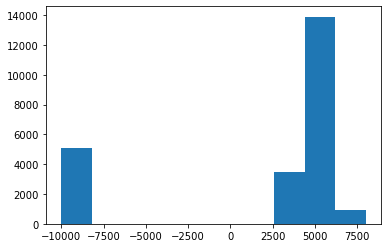

In [15]:
# plt.hist(kasc['BPG_DIST_MED'][np.where(kasc['BPG_DIST_MED']>0.)])
# plt.hist(kasc['DR14_FE_H'])
plt.hist(kasc['DR14_TEFF_FIT'])

In [20]:
age_dist = []

pca_transform = PCA(n_components=3).fit(np.array([parsec['logTe'],parsec['Ksmag'],parsec['MH'],parsec['logg']]).T)

for i in tqdm_notebook(range(len(np.squeeze(kasc))),desc='Done?'):
    # temperature
    teff = kasc['DR14_TEFF_FIT'][i]
#     teff_err = kasc['TEFF_ERR'][i]
    
    # photometry 
#     ra = kasc['RA'][i]
#     dec = kasc['DEC'][i]
    ks = kasc['K_MAG_2M'][i]
    ks_err = kasc['K_MAG_ERR'][i]
#     ak = kasc['AK_TARG'][i]
    dist = kasc['BPG_DIST_MED'][i]
    dist_err = 0.5*(kasc['BPG_DIST_68U']-kasc['BPG_DIST_68L'])[i]
    
    # abundances
    mh = kasc['DR14_FE_H'][i] #kasc['M_H'][i]
    mh_err = kasc['DR14_FE_H_ERR'][i] #kasc['M_H_ERR'][i]
    cfe = kasc['DR14_C_FE'][i]
    cfe_err = kasc['DR14_C_FE_ERR'][i]
    nfe = kasc['DR14_N_FE'][i]
    nfe_err = kasc['DR14_N_FE_ERR'][i]
    feh = kasc['DR14_FE_H'][i]
    feh_err = kasc['DR14_FE_H_ERR'][i]
#     am = kasc['ALPHA_M'][i]
#     am_err = kasc['ALPHA_M_ERR'][i]
    
    # surface gravity
    lgg = kasc['DR14_LOGG_FIT'][i]
#     lgg_err = kasc['LOGG_ERR'][i]
    
    noise_ages = []
    new = []
    for j in range(750):
       
        # calculate noisy temperature
        teff_new = teff #add_noise(teff,teff_err) 
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
        #_, _, dist = afunc.LMCdisk_cart(ra,dec)
        
        ks_new = ks #add_noise(ks,ks_err)
        
        dist_new = add_noise(dist,dist_err)
            
        absK_new = afunc.absmag(ks_new,dist_new) #- ak
            
        # Calculate noisy Salaris correction
        
        x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+
                                 add_noise(feh,feh_err)-add_noise(mh,mh_err))
        x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+
                                 add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
        ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        mh_new = add_noise(mh,mh_err)
#         am_new = add_noise(am,am_err)
        
        # Calculate noisy surface gravity
        lgg_new = lgg #add_noise(lgg,lgg_err)
            
        # calculate noisy age
        new.append(np.array([lgteff_new,absK_new,afunc.sal(mh_new,ffac_new),lgg_new]))
        
    zs = pca_transform.transform()#np.asarray(np.squeeze(new)))

    for l in range(len(zs)):
        noise_ages.append(age_model(zs[l][0],zs[l][1],zs[l][2]))
    
    age_dist.append(noise_ages)

parages = [] 
devs = []
for k in tqdm_notebook(range(len(age_dist))):
    devs.append(afunc.mad(age_dist[k]))
    parages.append(np.median(age_dist[k]))
devs = np.asarray(devs)
parages = np.asarray(parages)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').